<a href="https://colab.research.google.com/github/wellia/Machine_Learning/blob/main/weather_linear_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Background

Environment and its changes are the most complex system. It is unarguably accepted that the temperature changes are greately affected by various environmental factors. Many of them are positively related to the  change, whereas, some have negative correlation. In this assesment task, you will analyse relationship among various environmental factors, which affect temperature.

##The dataset

**Dataset file name:** weather_dataset.csv

**Dataset description:** The dataset contains total 10 features. Each row contains an hourly record of weather status and the data was recorded for the time period between 2006 and 2016.

**Features and labels:** 

1.   recording_date_time (date_time): Date and time the data was recorded
2.   precip_type (string): Precipitation status, blank (no value) indicates unknown status
3.   temperature (float): Temperature in degree Celsius
4.   apparent_temperature (float): Feel like temperature in degree Celsius
5.   humidity (float): Percentage amount of water vapour in the air 
6.   wind_speed (float): Speed of the wind in km per hour
7.   wind_bearing (int): The direction of wind in degree in geo-polar co-ordinate. Value 0 means perfect east, 90 means perfect north, 180 and 270 means west and south respectively.
8.   visibility (float): Distance in km that is visible in naked eyes.
9.   cloud_cover (float): The fraction of the sky obscured by clouds. The value is 1 if the observed area is fully cloudy, 0 if no clouds and other fractional value indicates the portion of the area covered by clouds.
10.   pressure (float): Air pressure or atmospheric in milibars


In [ ]:
!pip install imblearn

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, SGDRegressor
from sklearn.preprocessing import StandardScaler, binarize, PolynomialFeatures
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE

*Note*: I removed recording_date_time as per the instructions. I also removed cloud_cover, which contained only 0 and had no effect on the model. I did not remove humidity and pressure even though they potentially have outliers.


Any null?  False

Precip types: ['rain' 'snow']

Cloud cover: [0]
missing humidity: 22
missing pressure: 1288
train data shape: (78910, 8)
test data shape: (17543, 8)
Split is ok


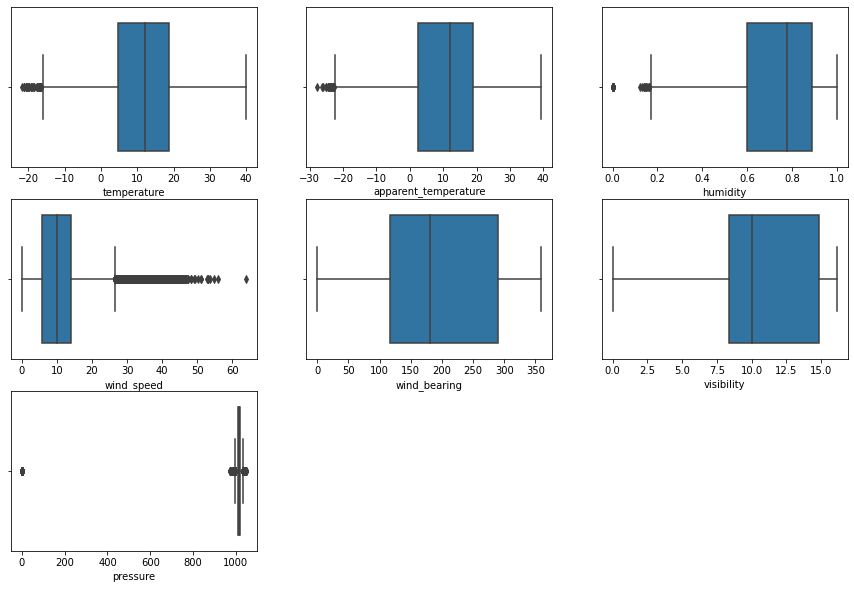

In [ ]:
# Part 1.1

# load data
df = pd.read_csv("weather_dataset.csv")

# convert categorical variable 0 rain, 1 snow
df['recording_date_time'] = pd.to_datetime(df['recording_date_time'], utc=True)
df['precip_type_dummy'] = df['precip_type'].astype('category').cat.codes

# check null data
print('Any null? ', df.isnull().values.any()) # print False, no null data

#  categorical variables
print('\nPrecip types:', df.precip_type.unique()) # print rain, show
print('\nCloud cover:', df.cloud_cover.unique()) # print 0

# From the plots, there are 2 concerns humidity and pressure, they have imposibble value 0

# check humidity data
missing_humidity = df[df.humidity==0]
print('missing humidity:', missing_humidity.shape[0]) # there are 22 rows with 0 value, 

# check pressure data
missing_pressure = df[df.pressure==0]
print('missing pressure:', missing_pressure.shape[0]) # there are 1288 rows with 0 value, 

# The cloud cover only contains 0, it is not useful to build a model
# also drop precip_type, we already have precip_type_dummy
df = df.drop(['cloud_cover', 'precip_type'], axis=1)

# split data - leave 2015 and 2016 data for testing
df['recording_date_time'].dt.year.unique()

df_test = df[df['recording_date_time'].dt.year.isin([2015, 2016])]
df_train = df[df['recording_date_time'].dt.year < 2015]

# exclude date column
df_test = df_test.drop(['recording_date_time'], axis=1)
df_train = df_train.drop(['recording_date_time'], axis=1)


# display shapes
print('train data shape:' , df_train.shape) #78910 rows, 8 columns
print('test data shape:', df_test.shape) #17543 rows, 8 columns
if df.shape[0] == df_train.shape[0] + df_test.shape[0]:
  print('Split is ok')
else:
  print('Split is wrong')
  
# visualisation of data
fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(3, 3, 1)
sns.boxplot(x=df['temperature'],ax=ax)
ax = fig.add_subplot(3, 3, 2)
sns.boxplot(x=df['apparent_temperature'],ax=ax)
ax = fig.add_subplot(3, 3, 3)
sns.boxplot(x=df['humidity'],ax=ax)
ax = fig.add_subplot(3, 3, 4)
sns.boxplot(x=df['wind_speed'],ax=ax)
ax = fig.add_subplot(3, 3, 5)
sns.boxplot(x=df['wind_bearing'],ax=ax)
ax = fig.add_subplot(3, 3, 6)
sns.boxplot(x=df['visibility'],ax=ax)
ax = fig.add_subplot(3, 3, 7)
sns.boxplot(x=df['pressure'],ax=ax)
plt.show()

2.  Consider the 'temperature' as the target. List the insignificant features for predicting temperature, if any. Explain your findings.

*Note*: The linear relationship between a predictor and a target is positive if the value is greater than zero. The closer the value is to one, the stronger the relationship. The graph supports the finding. If the correlation is insignificant, these predictors (wind_bearing and wind_speed) will have less influence in predicting the temperature. The results are:<br/>
<li>apparent_temperature has strong positive linear relationship</li>
<li>humidity and precip_type have strong negative LR</li>
<li>visibility and pressure have moderate positive LR</li>
<li>pressure has moderate negative LR</li>
<br/>Insignificant features:
<li>wind_bearing and wind_speed have low positive LR</li>


In [ ]:
# Part 1.2 - code block 1

# calc covariance between predictors and target
target = 'temperature'
feature_cols = ['apparent_temperature', 'humidity', 'precip_type_dummy', 'visibility',  
                'pressure', 'wind_bearing', 'wind_speed']

corr = df_train.corrwith(df_train[target]).sort_values(ascending=False)
print(corr) 

temperature             1.000000
apparent_temperature    0.992413
visibility              0.371181
wind_bearing            0.029754
wind_speed              0.010981
pressure               -0.010212
precip_type_dummy      -0.578431
humidity               -0.631624
dtype: float64


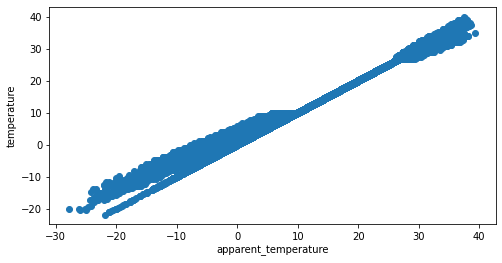

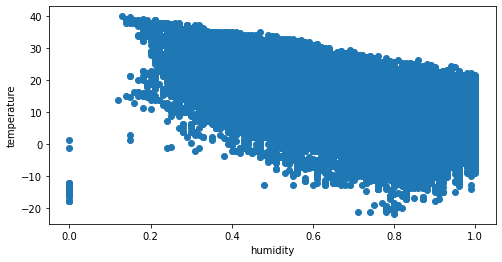

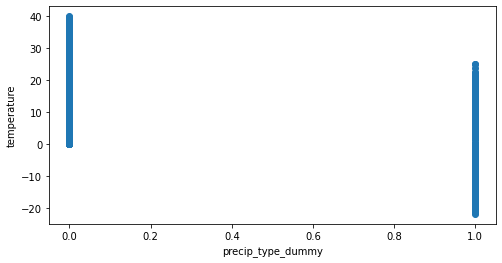

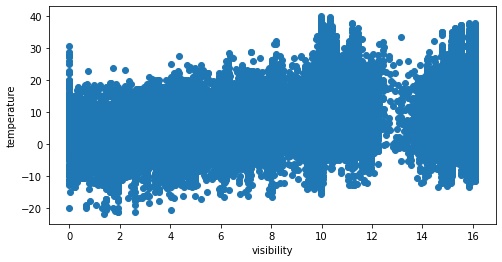

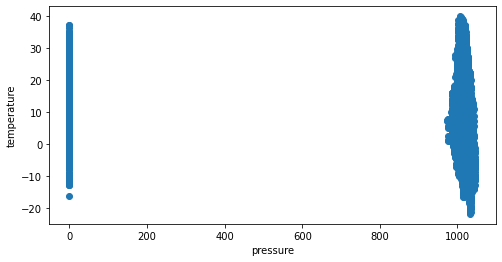

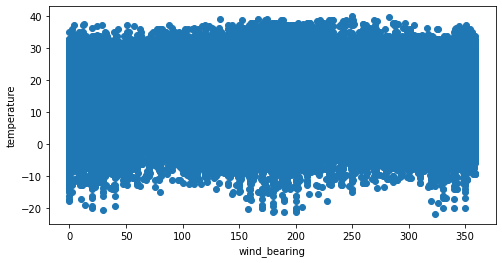

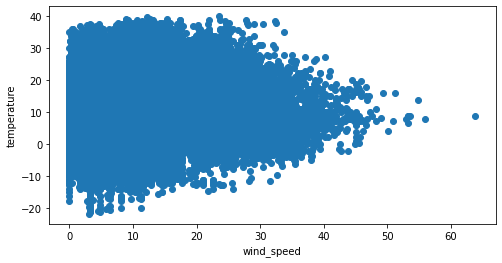

In [ ]:
# Part 1.2 - code block 2

# vizulisation to show linear relationship

def scatter_plot(feature, target):
    plt.figure(figsize=(8,4))
    plt.scatter(
        df[feature],
        df[target])
    plt.xlabel(feature)
    plt.ylabel('temperature')
    plt.show()
    
for feature in feature_cols:
   scatter_plot(feature, target)

##**Part 1: Linear Regression:**


1.   Load the dataset and split the data for training and testing - consider the data of last 2 years (2015 and 2016) for testing. Now exclude recording_date_time column from both training and test sets. Display the shape of training and test sets.

3.  Now create a linear model considering the 'temperature' as the target variable and other columns as features (you can optionally remove non-contributing features). Show the test performance (as Mean Absolute Error, MAE) of the model.
<br/><br/>*Note*: Initially I calculated the MAE based on features that have strong and moderate relatioships with temperature. I then added insignificant features. The result is, the model performs better with all features. Therefore, I include all the features when building the model (code block 1)
<br/><br/>I use cross validation kfold to build a model (code block 2). The MAE is 0.72
<br/><br/>The model is y = 11.88 + (9.42 * apparent_temperature) - (0.28 * humidity) + (0.02 * precip_type_dummy) + (0.03 * visibility) - (0.02 * pressure) + (0.58 * wind_speed) - (0.04 * wind_bearing))




In [ ]:
#Part 1.3 - code block 1 - linear model, test MAE for number of features 

def calculate_mae(features):
  print('\nlast feature:', features[len(features)-1])
  # Split the data in Part 1.1. test data are in year 2015 and 2016
  x_train = df_train[features]
  y_train = df_train[target]

  # normalize data
  x_train = scaler.fit_transform(x_train)

  # fit the model
  lr = LinearRegression()
  model = lr.fit(x_train,y_train)
  print('MAE on train data:', metrics.mean_absolute_error(y_train, model.predict(x_train)))
    
# features after selection
new_feature_cols = ['apparent_temperature', 'humidity', 'precip_type_dummy', 'visibility', 'pressure']
insignificant_feature_cols = ['wind_speed', 'wind_bearing']
scaler = StandardScaler()

calculate_mae(new_feature_cols)

for feature in insignificant_feature_cols:
    new_feature_cols = np.append(new_feature_cols, feature)
    calculate_mae(new_feature_cols)


last feature: pressure
MAE on train data: 0.8405426792586865

last feature: wind_speed
MAE on train data: 0.7486079493268681

last feature: wind_bearing
MAE on train data: 0.7478217624772675


In [ ]:
# Part 1.3 - code block 2 - use cross validation to build a model

# all features
feature_cols = ['apparent_temperature', 'humidity', 'precip_type_dummy', 'visibility', 'pressure', 'wind_speed', 'wind_bearing']
target = 'temperature'

x_train = df_train[feature_cols]
y_train = df_train[target]
x_test = df_test[feature_cols]
y_test = df_test[target]

# normalize data
scaler = StandardScaler()
x_train_scale = scaler.fit_transform(x_train)
x_test_scale = scaler.transform(x_test)

# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# specify range of hyperparameters
hyper_params = [{'n_features_to_select': list(range(2, 40))}]

# specify model
lm = LinearRegression()
lm.fit(x_train_scale, y_train)
rfe = RFE(lm)             

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model = model_cv.fit(x_train_scale, y_train) 
print('MAE on training data:', metrics.mean_absolute_error(y_train, model.predict(x_train_scale))) 
print('MAE on test data:', metrics.mean_absolute_error(y_test, model.predict(x_test_scale))) 
print('R-Square on test data:', metrics.r2_score(y_test, model.predict(x_test_scale)))
print('\nIntercept:' , lm.intercept_)

print('Coefficients:', tuple(zip(feature_cols, lm.coef_)))

features=list(x_train.columns[model_cv.best_estimator_.support_])
print('Features used:' , features)

Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


MAE on training data: 0.7478217624772675
MAE on test data: 0.7195984274620743
R-Square on test data: 0.9905007521466286

Intercept: 11.88448853123812
Coefficients: (('apparent_temperature', 9.416712306695599), ('humidity', -0.2813334035677037), ('precip_type_dummy', 0.014803289772776701), ('visibility', 0.031284989571188526), ('pressure', -0.020663523983878607), ('wind_speed', 0.5821546552327657), ('wind_bearing', -0.042434636860877256))
Features used: ['apparent_temperature', 'humidity', 'precip_type_dummy', 'visibility', 'pressure', 'wind_speed', 'wind_bearing']


[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:    5.6s finished


4.   Find the feature which shows maximum correlation with "pressure". Create a linear regression model to predict temperature using these two features ('pressure' and the one which shows maximum correlation). Compare the performance of this simplified model with the model developed in the previous question (Q-3). Explain the performance variation, if any.

*Note*: The feature with maximum correlation with "pressure" is visibility. Compared to the model developed earlier (which has an MAE of 0.72), this simplified model (with an MAE of 6.5) is worse. With the previous model, 99% of variances can be explained by the model's features. By contrast, with this simplified model, only 23.5% of variances can be explained by the model's features. This is because the previous model includes more features with strong correlation with temperature, whereas two features used when building this model (Pressure and precip_type) only have moderate correlation with temperature. 

In [ ]:
# Part 1.4 Find correlation with pressure

# all features
feature_pressure_cols = ['pressure','visibility']
target = 'temperature'

corr_press = df.corrwith(df['pressure']).sort_values(ascending=False)
print(corr_press) #visibility has the highest correlation with pressure with 0.06

# create linear model using pressure and visibility

x_train = df_train[feature_pressure_cols]
y_train = df_train[target]
x_test = df_test[feature_pressure_cols]
y_test = df_test[target]

# normalize data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# fit the model
lr = LinearRegression()
model = lr.fit(x_train,y_train)

# # find model accuracy
print('\nModel on training data:')
print('MAE on training data:', metrics.mean_absolute_error(y_train, model.predict(x_train)))
print('MAE on test data:', metrics.mean_absolute_error(y_test, model.predict(x_test)))
print('R-Square on test data:', metrics.r2_score(y_test, model.predict(x_test)))

pressure                1.000000
visibility              0.059826
precip_type_dummy       0.011103
humidity                0.005454
apparent_temperature   -0.000218
temperature            -0.005447
wind_bearing           -0.011651
wind_speed             -0.049260
dtype: float64

Model on training data:
MAE on training data: 7.233383801635007
MAE on test data: 6.497942083877327
R-Square on test data: 0.2350543695613977


5. Apportion the complete dataset into training and test sets, with an 40-60 split.

  (a)  Train a linear regression model without considering overfitting scenario and report the test performance. 
  <br/>*Note*: When run against the original dataset, the model is not overfitted (MAE on train data: 0.7422, MAE on test data: 0.7411). To make it overfitted, I added a noise feature and make features polynomial. The higher the degree in polynomial, the longer is the training time. 

  (b) Create an optimal regularised linear regression model and report the test performance.
  <br/>*Note*: After regularisation with Ridge and Lasso, the MAE results are well balanced between train and test data. Regularisation with Lasso performed better
<br/>LR (MAE train: 0.298842, MAE test: 0.321752)
<br/>Lasso (MAE train: 0.326707, MAE test: 0.329300)
<br/>Ridge (MAE train: 0.313823, MAE test: 0.322694)

  (c) Explain the reason behind the performance variation, if any.
  <br/>*Note*: Regularisation is used to solve overfitting problem, it penalises the complexity. The best learning rate is selected using cross validation. Regularisation does not improve accuracy, but solves the overfitting problem. Additional regularisation in polynomial features can be used for better performance. 

In [ ]:
# Part 1.5.a - Train a linear regression model

make_overfit = True # change to False to run linear regression on original data, the result will not overfit

df_5 = df.drop(['recording_date_time'], axis=1)

if make_overfit:
  df_5['noise'] = np.exp(df['apparent_temperature'])

# split random
y = df_5[target]
x = df_5.drop([target], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.6, random_state=1)

if make_overfit:
  n_degree = 3
  polynomial_features = PolynomialFeatures(degree = n_degree)
  x_train = polynomial_features.fit_transform(x_train)
  x_test = polynomial_features.fit_transform(x_test)

# normalize data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# fit the model
lr = LinearRegression()
model = lr.fit(x_train,y_train)
y_pred = model.predict(x_train)
print('MAE on train data:', metrics.mean_absolute_error(y_train, y_pred))  

y_pred = model.predict(x_test)
print('MAE on test data:', metrics.mean_absolute_error(y_test, y_pred))  

MAE on train data: 0.29884202469445037
MAE on test data: 0.32175217629296754


In [ ]:
# Part 1.5.b
# compare MAE for ordinary linear regression and regularization with lasso and ridge

# WARNING: The training time can be quite long

# I set iterations number low to reduce training time
def compare_result(models, data, iterations = 2):
    results = {}
    for i in models:
        mae_train = []
        mae_test = []
        for j in range(iterations):
            model = models[i].fit(x_train, y_train)
            mae_test.append( metrics.mean_absolute_error(y_test, model.predict(x_test)))
            mae_train.append(metrics.mean_absolute_error(y_train, model.predict(x_train)))
        results[i] = [np.mean(mae_train), np.mean(mae_test)]
    return pd.DataFrame(results)

lasso_params = {'alpha':[0.001, 0.005, 0.01, 0.02, 0.05, 0.9]}
ridge_params = {'alpha':[0.001, 0.1, 0.5, 2, 10, 50]}

lasso_grid = GridSearchCV(Lasso(max_iter=2000), param_grid=lasso_params).fit(x_train, y_train)
ridge_grid = GridSearchCV(Ridge(max_iter=100), param_grid=ridge_params).fit(x_train, y_train)

print('Best params lasso:', lasso_grid.best_estimator_)
print('Best params ridge:', ridge_grid.best_estimator_)

models = {'LR': LinearRegression(),
           'Lasso': lasso_grid.best_estimator_,
           'Ridge': ridge_grid.best_estimator_}
      
print('0: MAE on train data, 1: MAE on test data')
results = compare_result(models, df)
print(results)

Best params lasso: Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=2000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
Best params ridge: Ridge(alpha=2, copy_X=True, fit_intercept=True, max_iter=100, normalize=False,
      random_state=None, solver='auto', tol=0.001)
0: MAE on train data, 1: MAE on test data
         LR     Lasso     Ridge
0  0.298842  0.326707  0.313823
1  0.321752  0.329300  0.322694


##**Part 2: Logistic Regression:** 

1.  Can the same target (temperature, mentioned in Part-1) be used for logistic regression? Why?

*Note*: No, it cannot. logistic regression uses the logistic sigmoid function to return a probability value, which is then mapped to a class. The data type for Temperature is continuous so it cannot use logistic regression. Logistic regression is a classification algorithm.

2.  Split the dataset as 70-30% for training and testing. Create a logistic regression model to predict the 'precip_type'. Report the prediction accuracy of your model whether the "precip_type" is "rain" or not (use decision threshold of 0.45). 



In [ ]:
# part 2.2: logistic regression
df_logistic = df

# check data imbalance
target_count = df_logistic['precip_type_dummy'].value_counts()
print('Rain - 0:', target_count[0])
print('Snow - 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')


Rain - 0: 85224
Snow - 1: 11229
Proportion: 7.59 : 1


In [ ]:
# part 2.2: logistic regression

# define target and predictors
y = df_logistic['precip_type_dummy']
x = df_logistic.drop(['precip_type_dummy', 'recording_date_time'], axis=1)

columns = x.columns

# split data 70, 30
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, stratify=y)

# normalize data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# data imbalance, do resampling
os = SMOTE(random_state=0)
x_train_os,y_train_os = os.fit_sample(x_train, y_train)
x_train = pd.DataFrame(data=x_train_os,columns=columns )
y_train= pd.DataFrame(data=y_train_os,columns=['precip_type_dummy'])

# check new sample
print("Now length of data is ",len(x_train))
print("Rain:",len(y_train[y_train['precip_type_dummy']==0]))
print("Snow:",len(y_train[y_train['precip_type_dummy']==1]))
print("Proportion of rain:",len(y_train[y_train['precip_type_dummy']==0])/len(x_train))
print("Proportion of snow:",len(y_train[y_train['precip_type_dummy']==1])/len(x_train))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Now length of data is  119314
Rain: 59657
Snow: 59657
Proportion of rain: 0.5
Proportion of snow: 0.5


In [ ]:
# feature selections using recursive elimination

x_test = pd.DataFrame(data=x_test,columns=columns )

log_reg = LogisticRegression()
rfe = RFE(log_reg, n_features_to_select=5) 
rfe = rfe.fit(x_train, y_train.values.ravel())

for i in range(x_train.shape[1]):
    print('Column: %i %s, Selected %s, Rank: %.3f' % (i, columns[i], rfe.support_[i], rfe.ranking_[i]))
    
classifier = LogisticRegression(random_state=0, penalty= 'l2')
log_reg = classifier.fit(x_train[x_train.columns[rfe.support_]], y_train.values.ravel())

decision_threshold = 0.45 #class 1 (snow) if p > 0.45 otherwise class 0 (rain)

y_pred_prob = log_reg.predict_proba(x_test[x_train.columns[rfe.support_]])

y_pred = binarize(y_pred_prob, threshold=decision_threshold)[:,1]


Column: 0 temperature, Selected True, Rank: 1.000
Column: 1 apparent_temperature, Selected True, Rank: 1.000
Column: 2 humidity, Selected True, Rank: 1.000
Column: 3 wind_speed, Selected True, Rank: 1.000
Column: 4 wind_bearing, Selected False, Rank: 3.000
Column: 5 visibility, Selected True, Rank: 1.000
Column: 6 pressure, Selected False, Rank: 2.000


 3.  Discuss the test performance using precision, recall and confusion matrix. 
 <br/>I use these abbreviations: True Positive (TP), True Negative (TN), FP (False Positive), FN (False Negative)
 <br/> From the confusion matrix: the model predicted 23038 cases correctly as rain (TP). The model predicted 3290 cases correctly as snow (TN). Others cases are misclassifed. There are 2529 cases where the model predicted a sample as snow but it's actually rain (FN), there are 160 cases where the model predicted a sample as rain but it is actually snow (FP). 
<br/>From the accuracy score: My model has 90.7% accuracy (TP+TN/TP+FP+FN+TN)
<br/>From the precision score: 0.71 of samples that the model predicted as rain, are actually rain (TP/TP+FP)
<br/>From the recall score: Of all the actual rains, the model predicted 0.93 of the samples correctly as rain (TP/TP+FN)

In [ ]:
# part 2.2: test performance

# Predicting Test Set
print('\naccuracy:', accuracy_score(y_test, y_pred))

precision_metric = precision_score(y_test, y_pred, average = "macro")
print('Precision Metric:', precision_metric)

recall_metric = recall_score(y_test, y_pred, average = "macro")
print('\nRecall Metric:', recall_metric)

# confusion matrix
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
print('\nConfusion Matrix:')
print(confusion_matrix)


accuracy: 0.9070707768869228
Precision Metric: 0.7761784745989719

Recall Metric: 0.9267957952578818

Confusion Matrix:
Predicted    0.0   1.0
Actual                
0          23038  2529
1            160  3209


##**Part 3: Objective function optimisation:**  **(6 marks)**

Let’s consider the line graphs shown below and answer the following questions [Hint: See weekly content 7.4-7.10],

<html>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(a)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(b)</html>

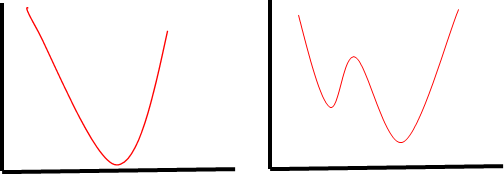





a.  Which of the above figures represents the convex objective function and why? 

*Answer*: 

Figure (a) represents the convex objective function, because the line segment between any two points in the function will always be above the graph portion between the two points.

b.  Which hyper-parameter can help to reach the convergence point and the impact of value selection?

*Answer*:

The learning rate. Impact of value selection: A learning rate that is too low will cause convergence to take a long time. A learning rate that is too high can make the learning jump over minima (overshooting)


c.  How can we find the global minima for the objective function shown in Figure-b? _[N.B. Conceptual description will be accepted.]_

*Answer*:

 In this case, a closed form formula is not available, so we need to solve it iteratively by performing Coordinate-wise Gradient Descent optimisation. 
We do this by first randomly initialising **w**. At each iteration, for j = 1 to d, we optimise wj, while fixing w1, ... 2j-1, wj+1, ... wd, using gradient descent.
We continue doing this until the objective function stops changing.